In [24]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tensorflow.keras import preprocessing
import sklearn
from sklearn import datasets
import inspect
import re
import kaggle
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [25]:
## count-based vectoeizer
A = np.array([[0,0,0,1,0,1,1,0,0],
              [0,0,0,1,1,0,1,0,0],
              [0,1,1,0,2,0,0,0,0],
              [1,0,0,0,0,0,0,1,1]])

A.shape

(4, 9)

In [26]:
U, s, VT = np.linalg.svd(A, full_matrices = True)

print('U:')
print(U.round(3))

print('s:')
print(s.round(3))

print('VT:')
print(VT.round(3))

U:
[[-0.24   0.751  0.    -0.615]
 [-0.506  0.444 -0.     0.739]
 [-0.828 -0.489 -0.    -0.274]
 [-0.    -0.     1.     0.   ]]
s:
[2.687 2.045 1.732 0.772]
VT:
[[-0.    -0.308 -0.308 -0.278 -0.805 -0.089 -0.278 -0.    -0.   ]
 [ 0.    -0.239 -0.239  0.584 -0.261  0.367  0.584 -0.    -0.   ]
 [ 0.577 -0.     0.     0.    -0.     0.    -0.     0.577  0.577]
 [ 0.    -0.354 -0.354  0.161  0.249 -0.797  0.161 -0.    -0.   ]
 [-0.    -0.779 -0.013 -0.198  0.396  0.396 -0.198  0.     0.   ]
 [-0.289  0.312 -0.781 -0.242  0.234  0.234  0.008  0.144  0.144]
 [-0.289 -0.104  0.26  -0.586 -0.078 -0.078  0.664  0.144  0.144]
 [-0.5   -0.06   0.15   0.239 -0.045 -0.045 -0.194  0.75  -0.25 ]
 [-0.5   -0.06   0.15   0.239 -0.045 -0.045 -0.194 -0.25   0.75 ]]


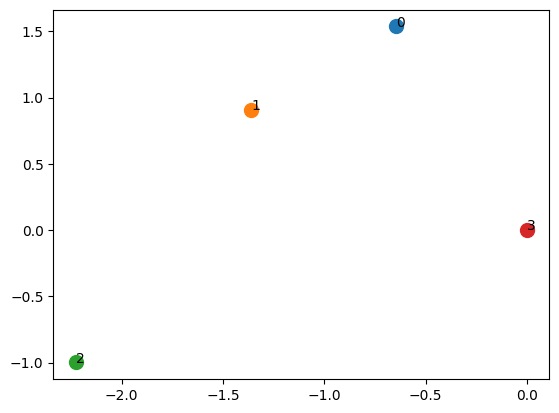

In [27]:
svd_matrix = np.hstack([U[:, 0:1]*s[0], U[:, 1:2]*s[1]])

for i in range(4):
    plt.plot(svd_matrix[i, 0], svd_matrix[i, 1], 'o', markersize = 10)
    plt.text(svd_matrix[i, 0], svd_matrix[i, 1], i)
    
plt.show()

In [28]:
sent = ("휴일 인 오늘 도 서쪽 을 중심 으로 폭염 이 이어졌는데요, 내일 은 반가운 비 소식 이 있습니다.", 
        "폭염 을 피해서 휴일 에 놀러왔다가 갑작스런 비 로 인해 망연자실 하고 있습니다.") 

In [31]:
countVectorizer = CountVectorizer()
countVectorizer.fit(sent)
print(countVectorizer.vocabulary_)

count_vec = countVectorizer.transform(sent)
count_vec.toarray()

{'휴일': 16, '오늘': 7, '서쪽': 5, '중심': 12, '으로': 8, '폭염': 13, '이어졌는데요': 9, '내일': 1, '반가운': 4, '소식': 6, '있습니다': 11, '피해서': 14, '놀러왔다가': 2, '갑작스런': 0, '인해': 10, '망연자실': 3, '하고': 15}


array([[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]], dtype=int64)

In [36]:
count_vector = count_vec.toarray()
print(type(count_vector))

print(count_vector[0] == count_vector[1])
union_vec = sum(count_vector[0] == count_vector[1])
print(union_vec)
count_vec.shape[1]

jaccard = union_vec/count_vec.shape[1]
print(jaccard.round(3))

<class 'numpy.ndarray'>
[False False False False False False False False False False False  True
 False  True False False  True]
3
0.176


In [37]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

In [40]:
## count vector
cos_dis_count = cosine_distances(count_vec[0:1], count_vec[1:2])
print(cos_dis_count)

cos_dis_tfidf = cosine_distances(count_vec[0:1], count_vec[1:2])
print(cos_dis_tfidf)

[[0.69848866]]
[[0.69848866]]


In [41]:
data_set = tf.keras.utils.get_file(
    fname = 'imdb.tar.gz',
    origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    extract=True
)

84125825/84125825 [==============================] - 96s 1us/step


In [47]:
import os
import glob

In [43]:
os.path.dirname('./aclImdb/')
os.path.join(os.path.dirname('./aclImdb/'), 'train', 'pos')

'./aclImdb\\train\\pos'

In [59]:
folder_path = os.path.dirname('./aclImdb/')
tt_lists = ['train', 'test']
pn_lists = ['pos', 'neg']

# file_paths = []
data = {}
for i in tt_lists:
    for j in pn_lists:
        # file_path = os.path.join(folder_path, i, j)
        # file_paths.append(file_path)
        
        file_paths = glob.glob(os.path.join(folder_path, i, j, "*.*"))
        
        data[i+"_"+j] = []
        
        for k in file_paths:
            with open(k, 'rt', encoding='utf-8') as f:
                data[i+"_"+j].append(f.read())
        
# display(file_paths)

In [63]:
print(type(data['train_pos']))

data_train_pos = pd.DataFrame(data['train_pos'], columns=['review'])
data_train_pos['sentiment'] = 1
data_train_pos.head()

data_train_neg = pd.DataFrame(data['train_neg'], columns=['review'])
data_train_neg['sentiment'] = 0
data_train_neg.head()

train_df = pd.concat([data_train_pos, data_train_neg], ignore_index=True)
train_df.shape
train_df.head()
train_df.tail()

<class 'list'>


,review,sentiment
24995,"Towards the end of the movie, I felt it was to...",0
24996,This is the kind of movie that my enemies cont...,0
24997,I saw 'Descent' last night at the Stockholm Fi...,0
24998,Some films that you pick up for a pound turn o...,0
24999,"This is one of the dumbest films, I've ever se...",0


In [66]:
review = train_df['review']
review[0]
review[1]

'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they\'ll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it\'s like to be homeless? That is Goddard Bolt\'s lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days withou

In [75]:
tokenized_review = [len(x.split()) for x in review]
print(tokenized_review)
eumjeol_review = [len(x.replace(' ', '')) for x in review]
print(eumjeol_review)

[140, 428, 147, 124, 120, 171, 108, 340, 436, 324, 280, 86, 282, 224, 145, 158, 195, 279, 129, 152, 214, 556, 168, 179, 141, 104, 109, 310, 150, 142, 244, 119, 159, 165, 437, 453, 54, 298, 221, 331, 356, 160, 527, 242, 112, 331, 966, 544, 87, 1839, 436, 541, 182, 539, 202, 715, 180, 162, 54, 278, 93, 181, 133, 216, 316, 165, 103, 223, 106, 96, 124, 194, 291, 322, 44, 148, 107, 326, 71, 224, 115, 262, 111, 117, 55, 56, 268, 129, 169, 159, 249, 76, 196, 119, 164, 55, 63, 101, 137, 166, 168, 216, 114, 160, 588, 159, 272, 242, 146, 507, 225, 337, 193, 54, 163, 116, 274, 395, 272, 354, 187, 104, 222, 197, 140, 221, 512, 159, 112, 110, 157, 142, 221, 145, 323, 171, 143, 211, 629, 237, 319, 199, 341, 135, 303, 103, 130, 160, 121, 649, 141, 172, 414, 299, 498, 329, 392, 153, 153, 185, 185, 133, 136, 295, 499, 90, 391, 333, 154, 149, 95, 148, 145, 173, 74, 110, 124, 133, 114, 390, 145, 123, 137, 147, 157, 220, 129, 133, 132, 147, 200, 135, 457, 273, 161, 421, 401, 161, 155, 150, 267, 183, 134, 

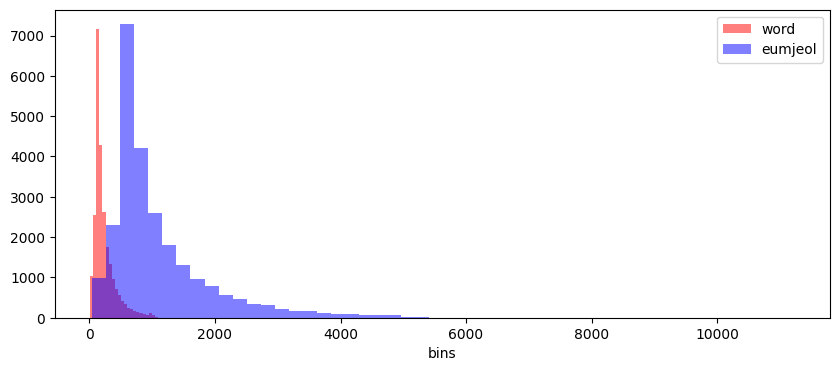

In [77]:
plt.figure(figsize=(10, 4))

plt.hist(tokenized_review, bins=50, color='r', alpha = 0.5, label='word')
plt.hist(eumjeol_review, bins=50, color='b', alpha = 0.5, label='eumjeol')
plt.xlabel('bins')
plt.legend()
plt.show()

In [79]:
# EDA

print('문장 최대 길이: {}'.format(np.max(tokenized_review)))
print('문장 최소 길이: {}'.format(np.min(tokenized_review)))

문장 최대 길이: 2470
문장 최소 길이: 10


In [80]:
! pip install wordcloud

     -------------------------------------- 153.3/153.3 kB 1.1 MB/s eta 0:00:00


In [81]:
from wordcloud import WordCloud, STOPWORDS

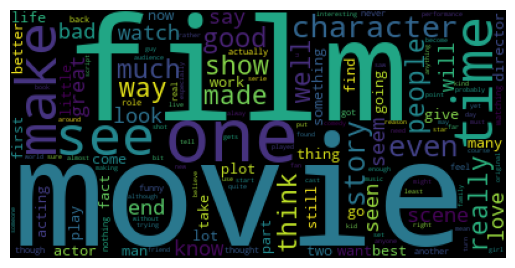

In [89]:
# STOPWORDS

MY_STOPWORDS = list(STOPWORDS) + ['br']
MY_STOPWORDS = set(MY_STOPWORDS)

x = ' '.join(review)
# len(x)
word_cloud = WordCloud(stopwords=MY_STOPWORDS)
word_cloud.generate(x)

plt.imshow(word_cloud)
plt.axis('off')
plt.show()